In [1]:
from copy import copy
import argparse
from tqdm import tqdm

import sys
sys.argv=['']
del sys

from sklearn.metrics import f1_score
from pyHGT.data import *
from pyHGT.model import *
from warnings import filterwarnings
filterwarnings("ignore")

import torch
import torch.nn.functional as F
from torch.nn import ModuleList, Linear, ParameterDict, Parameter
from torch_geometric.utils import to_undirected
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator


def dict_to_args(_dict):
    res = []
    for key in _dict:
        res += ['--' + key]
        if _dict[key] is not None:
            res += [_dict[key]]
    return res


parser = argparse.ArgumentParser(description='Training GNN on Paper-Field (L2) classification task')


parser.add_argument('--cuda', type=int, default=0,
                    help='Avaiable GPU ID')
parser.add_argument('--conv_name', type=str, default='hgt',
                    choices=['hgt', 'gcn', 'gat', 'rgcn', 'han', 'hetgnn'],
                    help='The name of GNN filter. By default is Heterogeneous Graph Transformer (hgt)')
parser.add_argument('--n_hid', type=int, default=128,
                    help='Number of hidden dimension')
parser.add_argument('--n_heads', type=int, default=4,
                    help='Number of attention head')
parser.add_argument('--n_layers', type=int, default=2,
                    help='Number of GNN layers')
parser.add_argument('--dropout', type=int, default=0.5,
                    help='Dropout ratio')
parser.add_argument('--sample_depth', type=int, default=7,
                    help='How many numbers to sample the graph')
parser.add_argument('--sample_width', type=int, default=768,
                    help='How many nodes to be sampled per layer per type')
parser.add_argument('--prev_norm', help='Whether to add layer-norm on the previous layers', action='store_true')
parser.add_argument('--last_norm', help='Whether to add layer-norm on the last layers',     action='store_true')
parser.add_argument('--use_RTE',   help='Whether to use RTE',     action='store_true')

'''
    Optimization arguments
'''
parser.add_argument('--optimizer', type=str, default='adamw',
                    choices=['adamw', 'adam', 'sgd', 'adagrad'],
                    help='optimizer to use.')
parser.add_argument('--n_epoch', type=int, default=100,
                    help='Number of epoch to run')
parser.add_argument('--n_pool', type=int, default=8,
                    help='Number of process to sample subgraph')    
parser.add_argument('--n_batch', type=int, default=32,
                    help='Number of batch (sampled graphs) for each epoch') 
parser.add_argument('--batch_size', type=int, default=128,
                    help='Number of output nodes for training')    
parser.add_argument('--clip', type=int, default=1.0,
                    help='Gradient Norm Clipping') 
KWARGS = {
    'last_norm' :   None,
    'prev_norm' :   None,
    'n_layers'  :   '6',
    'n_hid'     :   '256',
    'n_heads'   :   '4',
    'cuda'      :   '3',
    'n_epoch'   :   '100'
}
args = parser.parse_args(args = dict_to_args(KWARGS))
print(args)

Namespace(batch_size=128, clip=1.0, conv_name='hgt', cuda=3, dropout=0.5, last_norm=True, n_batch=32, n_epoch=100, n_heads=4, n_hid=256, n_layers=6, n_pool=8, optimizer='adamw', prev_norm=True, sample_depth=7, sample_width=768, use_RTE=False)


Using backend: pytorch


In [2]:
graph = dill.load(open('/datadrive/dataset/OGB_products.pk', 'rb'))
graph.node_feature = {'def': graph.node_feature['def']}
evaluator = Evaluator(name='ogbn-products')

In [3]:
def feature_MAG(layer_data, graph):
    feature = {}
    times   = {}
    indxs   = {}
    texts   = []
    for _type in layer_data:
        if len(layer_data[_type]) == 0:
            continue
        idxs  = np.array(list(layer_data[_type].keys()), dtype = np.int)
        tims  = np.array(list(layer_data[_type].values()))[:,1]
        feature[_type] = graph.node_feature[_type][idxs]
        times[_type]   = tims
        indxs[_type]   = idxs
        
    return feature, times, indxs, texts

In [4]:
def node_classification_sample(seed, samp_nodes):
    np.random.seed(seed)
    ylabel      = torch.LongTensor(graph.y[samp_nodes])
    feature, times, edge_list, indxs, _ = sample_subgraph(graph, \
                inp = {'def': np.concatenate([samp_nodes, np.ones(len(samp_nodes))]).reshape(2, -1).transpose()}, \
                sampled_depth = args.sample_depth, sampled_number = args.sample_width, \
                    feature_extractor = feature_MAG)
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict = \
            to_torch(feature, times, edge_list, graph)
    train_mask = graph.train_mask[indxs['def']]
    valid_mask = graph.valid_mask[indxs['def']]
    test_mask  = graph.test_mask[indxs['def']]
    ylabel     = graph.y[indxs['def']]
    return node_feature, node_type, edge_time, edge_index, edge_type, (train_mask, valid_mask, test_mask), ylabel
    
def prepare_data(pool, task_type = 'train', s_idx = 0, n_batch = args.n_batch, batch_size = args.batch_size):
    '''
        Sampled and prepare training and validation data using multi-process parallization.
    '''
    jobs = []
    if task_type == 'train':
        for batch_id in np.arange(n_batch):
            p = pool.apply_async(node_classification_sample, args=([randint(), \
                            np.random.choice(graph.train_paper, args.batch_size, replace = False)]))
            jobs.append(p)
    elif task_type == 'test':
        for i in np.arange(n_batch):
            target_papers = graph.test_paper[(s_idx + i) * batch_size : (s_idx + i + 1) * batch_size]
            p = pool.apply_async(node_classification_sample, args=([randint(), target_papers]))
            jobs.append(p)
    elif task_type == 'ensemble':
        target_papers = graph.test_paper[s_idx * args.batch_size : (s_idx + 1) * args.batch_size]
        for batch_id in np.arange(n_batch):
            p = pool.apply_async(node_classification_sample, args=([randint(), target_papers]))
            jobs.append(p)
    return jobs

In [5]:
device = torch.device("cuda:%d" % args.cuda)
gnn = GNN(conv_name = args.conv_name, in_dim = len(graph.node_feature['def'][0]), \
          n_hid = args.n_hid, n_heads = args.n_heads, n_layers = args.n_layers, dropout = args.dropout,\
          num_types = len(graph.get_types()), num_relations = len(graph.get_meta_graph()) + 1,\
          prev_norm = args.prev_norm, last_norm = args.last_norm, use_RTE = args.use_RTE)
classifier = Classifier(args.n_hid, graph.y.max().item()+1)

model = nn.Sequential(gnn, classifier).to(device)
criterion = nn.NLLLoss()

In [6]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],     'weight_decay': 0.0}
    ]


optimizer = torch.optim.AdamW(optimizer_grouped_parameters, eps=1e-06)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.05, anneal_strategy='linear', final_div_factor=10,\
                        max_lr = 1e-3, total_steps = args.n_batch * args.n_epoch + 1)

stats = []
res   = []
best_val   = 0
train_step = 0

pool = mp.Pool(args.n_pool)
st = time.time()
jobs = prepare_data(pool)

Data Preparation: 29.2s
UPDATE!!!  0.3472517812264671
Epoch: 1 LR: 0.00023 Train Loss: 2.6511 Train Acc: 0.3693 Valid Acc: 0.3473 Test Acc: 0.3116
Data Preparation: 2.6s
UPDATE!!!  0.6521230767140727
Epoch: 2 LR: 0.00043 Train Loss: 1.2206 Train Acc: 0.6891 Valid Acc: 0.6521 Test Acc: 0.5843
Data Preparation: 2.3s
UPDATE!!!  0.770525574431269
Epoch: 3 LR: 0.00062 Train Loss: 0.8271 Train Acc: 0.7840 Valid Acc: 0.7705 Test Acc: 0.6763
Data Preparation: 2.8s
UPDATE!!!  0.8019277507691466
Epoch: 4 LR: 0.00081 Train Loss: 0.7202 Train Acc: 0.8095 Valid Acc: 0.8019 Test Acc: 0.7067
Data Preparation: 2.6s
UPDATE!!!  0.8114965759087115
Epoch: 5 LR: 0.00100 Train Loss: 0.6462 Train Acc: 0.8287 Valid Acc: 0.8115 Test Acc: 0.7219
Data Preparation: 2.4s
UPDATE!!!  0.8185944803630639
Epoch: 6 LR: 0.00099 Train Loss: 0.6143 Train Acc: 0.8322 Valid Acc: 0.8186 Test Acc: 0.7379
Data Preparation: 2.5s
UPDATE!!!  0.8243840606518363
Epoch: 7 LR: 0.00098 Train Loss: 0.5692 Train Acc: 0.8476 Valid Acc: 0.

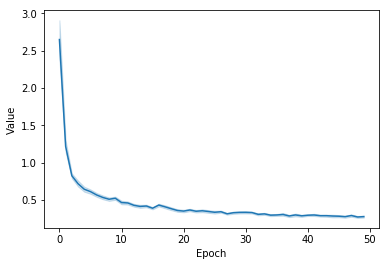

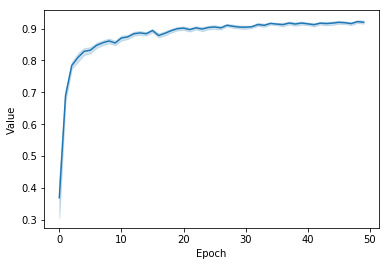

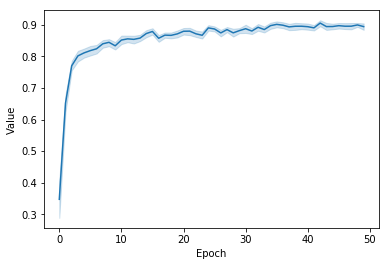

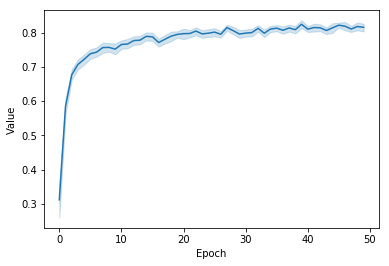

Data Preparation: 6.5s
Epoch: 51 LR: 0.00052 Train Loss: 0.2750 Train Acc: 0.9199 Valid Acc: 0.8949 Test Acc: 0.8116
Data Preparation: 2.5s
Epoch: 52 LR: 0.00051 Train Loss: 0.2879 Train Acc: 0.9161 Valid Acc: 0.8932 Test Acc: 0.8048
Data Preparation: 3.0s
Epoch: 53 LR: 0.00050 Train Loss: 0.2817 Train Acc: 0.9182 Valid Acc: 0.8973 Test Acc: 0.8075
Data Preparation: 2.4s
Epoch: 54 LR: 0.00049 Train Loss: 0.2641 Train Acc: 0.9262 Valid Acc: 0.9011 Test Acc: 0.8197
Data Preparation: 2.5s


In [ ]:
for epoch in np.arange(args.n_epoch) + 1:
    '''
        Prepare Training and Validation Data
    '''
    datas = [job.get() for job in jobs]
    pool.close()
    pool.join()
    '''
        After the data is collected, close the pool and then reopen it.
    '''
    pool = mp.Pool(args.n_pool)
    jobs = prepare_data(pool)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    '''
        Train
    '''
    model.train()
    stat = []
    for node_feature, node_type, edge_time, edge_index, edge_type, (train_mask, valid_mask, test_mask), ylabel in datas:
        node_rep = gnn.forward(node_feature.to(device), node_type.to(device), \
                               edge_time.to(device), edge_index.to(device), edge_type.to(device))
        ylabel = torch.LongTensor(ylabel).to(device)
        train_res  = classifier.forward(node_rep[:len(ylabel)][train_mask])
        valid_res  = classifier.forward(node_rep[:len(ylabel)][valid_mask])
        test_res   = classifier.forward(node_rep[:len(ylabel)][test_mask])

        train_loss = criterion(train_res, ylabel[train_mask].squeeze())

        optimizer.zero_grad() 
        train_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()

        train_step += 1
        scheduler.step(train_step)

        train_acc  = evaluator.eval({
                        'y_true': ylabel[train_mask],
                        'y_pred': train_res.argmax(dim=1).unsqueeze(-1)
                    })['acc']
        valid_acc  = evaluator.eval({
                        'y_true': ylabel[valid_mask],
                        'y_pred': valid_res.argmax(dim=1).unsqueeze(-1)
                    })['acc']
        test_acc   = evaluator.eval({
                        'y_true': ylabel[test_mask],
                        'y_pred': test_res.argmax(dim=1).unsqueeze(-1)
                    })['acc']
        stat += [[train_loss.item(), train_acc, valid_acc, test_acc]]
        del node_rep, train_loss, ylabel
    stats += [stat]
    avgs = np.average(stat, axis=0)
    if avgs[2] > best_val:
        best_val = avgs[2]
        torch.save(model, './model_yyy_RTE_6_product')
        print('UPDATE!!!  ' + str(best_val))
    print('Epoch: %d LR: %.5f Train Loss: %.4f Train Acc: %.4f Valid Acc: %.4f Test Acc: %.4f' % \
         (epoch,  optimizer.param_groups[0]['lr'], avgs[0], avgs[1], avgs[2], avgs[3]))
    st = time.time()
    if epoch % 50 == 0:
        s = np.concatenate(stats)
        for i in range(4):
            data = np.stack((s[-args.n_batch * 100:, i], np.arange(len(s[-args.n_batch * 100:, i])) // args.n_batch), axis=0).transpose()
            sb.lineplot(data = pd.DataFrame(data, columns = ['Value', 'Epoch']), x='Epoch', y='Value')
            plt.show()